## Discrete-Discrete HMM from scratch

For references check:
- Hidden Markov models and dynamical systems (Andrew M. Fraser)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

## Test data preparation

### Simulated problem
Problem parameters
- n_states = 2
- p_0 = {0: 1/4, 1: 1/2, 2: 1/4}
- p_1 = {-1: 1/2, 1: 1/5, 2: 3/10}
- p00 = 0.8
- p11 = 0.9

In [11]:
p00=0.8
p11=0.9
pss = [{0:p00, 1:1-p00},{0:1-p11, 1:p11}]
pys = [{-1: 0.1, 0: 0.25, 1: 0.4, 2: 0.25},{-1: 0.5, 0: 0.1, 1: 0.3, 2: 0.1}]
# pys = [{-1: .997, 0: 0.001, 1: 0.001, 2: 0.001},{-1: 0.001, 0: 0.001, 1: 0.001, 2: .997}]

N = 100

In [12]:
x = np.zeros(N)
s_true = np.zeros(N)
s_true[0] = 0

def random_draw(p):
    cumprob=0
    r = np.random.rand()
    for k in p.keys():
        cumprob += p[k]
        if r<cumprob:
            return k
            
x[0] = random_draw(pys[0])

for i in range(1,N-1):
    r = np.random.rand()
    if s_true[i] == 0:
        x[i] = random_draw(pys[0])
        if r > p00:
            s_true[i+1] = 1
        else:
            s_true[i+1] = s_true[i]
    else:
        x[i] = random_draw(pys[1])
        if r > p11:
            s_true[i+1] = 0
        else:
            s_true[i+1] = 1
if s_true[-1] == 0:
    x[-1] = random_draw(pys[0])
else:
    x[-1] = random_draw(pys[1])

y = x.astype(int)

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

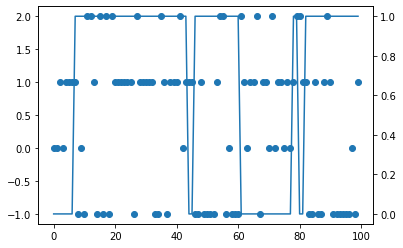

In [13]:
fig,ax = plt.subplots()
ax.scatter(np.arange(N),y)
ax2 = ax.twinx()
ax2.plot(np.arange(N),s_true)
fig.show

## Algorithms

### Forward Algorithm

In [5]:
# Parameters
ss = np.array([0,1]).astype(int)
ps0 = [0.5,0.5]
pys = [{-1: 0.1, 0: 0.25, 1: 0.4, 2: 0.25},{-1: 0.5, 0: 0.1, 1: 0.3, 2: 0.1}]
p00=0.8
p11=0.9
pss = [{0:p00, 1:1-p00},{0:1-p11, 1:p11}]
y = x.astype(int)
N = 100

In [88]:
alfas = np.full([2,N],np.nan)
gammas = np.full(N,np.nan)
t = 0
for state in ss:
    alfas[state,t] = ps0[state]*pys[state][y[t]]/sum(ps0[s]*pys[s][y[t]] for s in ss)
gammas[t] = 0

t += 1
aux = np.full(2,np.nan)
for state in ss:
    aux[state] = pys[state][y[t]]*alfas[state,t-1]
gammas[t] = sum(aux[state] for state in ss)
for state in ss:
    alfas[state,t] = aux[state]/gammas[t]
gammas

array([0.        , 0.18571429,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [94]:
t += 1
for state in ss:
    alfas[state,t-1] = sum(pss[s][state]*alfas[s][t-1] for s in ss)
for state in ss:
    aux[state] = pys[state][y[t]]*alfas[state,t-1]
gammas[t] = sum(aux[state] for state in ss)
for state in ss:
    alfas[state,t] = aux[state]/gammas[t]
gammas

array([0.        , 0.18571429, 0.19315385, 0.19881004, 0.20146131,
       0.36098936, 0.35665777, 0.18887203,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [101]:
def FA(y,ps0,pys,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: vector of dictionaries containing the probability for each y given s. E.g. [{3:0.4, 4:0.6},{3:0.9, 4:0.1}]. Both dictionaries must contain the same keys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = ps0.shape[0]
    ss = np.arange(n_states)

    alfas = np.full([n_states,N],np.nan)
    gammas = np.full(N,np.nan)
    t = 0
    for state in ss:
        alfas[state,t] = ps0[state]*pys[state][y[t]]/sum(ps0[s]*pys[s][y[t]] for s in ss)
    gammas[t] = 1

    t += 1
    aux = np.full(2,np.nan)
    for state in ss:
        aux[state] = pys[state][y[t]]*alfas[state,t-1]
    gammas[t] = sum(aux[state] for state in ss)
    for state in ss:
        alfas[state,t] = aux[state]/gammas[t]


    for t in range(2,N):
        for state in ss:
            alfas[state,t-1] = sum(pss[s][state]*alfas[s][t-1] for s in ss)
            aux[state] = pys[state][y[t]]*alfas[state,t-1]
        gammas[t] = sum(aux[state] for state in ss)
        for state in ss:
            alfas[state,t] = aux[state]/gammas[t]
    
    p = np.exp(np.sum(np.log(gammas))) # summing logs instead of multiplying probabilities to avoid underflow. Probability of y(0) ignored
    return p,alfas,gammas

In [15]:
def FA2(y,ps0,pys,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: vector of dictionaries containing the probability for each y given s. E.g. [{3:0.4, 4:0.6},{3:0.9, 4:0.1}]. Both dictionaries must contain the same keys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = len(ps0)
    ss = np.arange(n_states)

    alfas = np.full([n_states,N],np.nan)
    gammas = np.full(N,np.nan)
    
    t = 0
    for state in ss:
        alfas[state,t] = ps0[state]*pys[state][y[t]]/sum(ps0[s]*pys[s][y[t]] for s in ss)
    gammas[t] = 1
    aux = dc(alfas)
    aux2 = np.full([n_states,N],np.nan)

    for t in range(1,N):
        for state in ss:
            aux[state,t-1] = sum(pss[s][state]*alfas[s,t-1] for s in ss)
            aux2[state,t] = pys[state][y[t]]*aux[state,t-1]
        gammas[t] = sum(aux2[s,t] for s in ss)
        for state in ss:
            alfas[state,t] = aux2[state,t]/gammas[t]

    p = np.exp(np.sum(np.log(gammas))) # summing logs instead of multiplying probabilities to avoid underflow. Probability of y(0) ignored
    return p,alfas,gammas

p,alfas,gammas = FA2(y,ps0,pys,pss)

3.405362612103321e-55 3.405362612103329e-55


### Backward Algorithm

In [203]:
# Parameters
ss = np.array([0,1]).astype(int)
n_states = 2
ps0 = np.array([0.5,0.5])
pys = [{-1: 0.1, 0: 0.25, 1: 0.4, 2: 0.25},{-1: 0.5, 0: 0.1, 1: 0.3, 2: 0.1}]
p00=0.8
p11=0.9
pss = [{0:p00, 1:1-p00},{0:1-p11, 1:p11}]
y = x.astype(int)
N = 100

In [116]:
_, alfas, gammas = FA(y, ps0, pys,pss)
betas = np.full([n_states,N],np.nan)
t = N-1
for s in ss: betas[s,t] = 1

In [119]:
for state in ss:
    betas[state,t-1] = sum(betas[s,t]*pys[s][y[t]]*pss[state][s]/gammas[t] for s in ss)
t -= 1

In [22]:
def BA(y,ps0,pys,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: vector of dictionaries containing the probability for each y given s. E.g. [{3:0.4, 4:0.6},{3:0.9, 4:0.1}]. Both dictionaries must contain the same keys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = len(ps0)
    ss = np.arange(n_states)

    _, _, gammas = FA2(y,ps0,pys,pss)
    betas = np.full([n_states,N],np.nan)
    for s in ss: betas[s,N-1] = 1

    for t in range(N-1,0,-1):
        for state in ss:
            betas[state,t-1] = sum(betas[s,t]*pys[s][y[t]]*pss[state][s]/gammas[t] for s in ss)
    
    return betas
BA(y,ps0,pys,pss)

array([[1.24522747, 1.13274575, 1.19888564, 1.06276602, 1.0483721 ,
        0.98725494, 0.87061077, 0.68163726, 1.28187966, 0.74196079,
        2.08999549, 1.24356828, 0.82463541, 0.61898443, 1.09036801,
        0.5946266 , 1.37627839, 0.75917466, 2.36069208, 1.39595751,
        1.30500692, 1.22567048, 1.14651998, 1.05615396, 0.94155544,
        0.78621674, 2.00997199, 1.23577551, 1.13828741, 1.03255702,
        0.90335415, 0.73206742, 0.49402338, 0.54877056, 1.64930405,
        0.88740609, 0.69449178, 2.0049186 , 1.84032931, 1.74253027,
        1.69743376, 1.25041909, 1.00894453, 0.91832666, 0.75612066,
        0.49896116, 0.35683961, 0.53542111, 0.30983079, 0.28733786,
        0.3199102 , 0.53867476, 1.82431515, 1.61079798, 0.95148355,
        0.58078091, 0.81933785, 0.40467441, 0.3807028 , 0.77305837,
        3.1612526 , 1.79278487, 1.71837203, 1.22275483, 1.19392508,
        1.15407276, 0.87612757, 1.96553102, 1.89386591, 1.88550471,
        1.43425864, 1.23898838, 1.14236189, 1.22

### Viterbi Algorithm

In [202]:
v = np.full([n_states,N],np.nan)
w = np.full([n_states,n_states,N],np.nan)
B = np.full([n_states,N],np.nan)

for s in ss:
    v[s,0] = pys[s][y[0]]
t = 0


In [187]:
for t in range(1,N):
    for s_new in ss:
        best = -np.Inf
        best_s = np.nan
        for s_old in ss:
            w[s_old,s_new,t] = v[s_old,t-1] + np.log(pss[s_old][s_new]) + np.log(pys[s_new][y[t]])
            if w[s_old,s_new,t] > best: 
                best = w[s_old,s_new,t]
                best_s = s_old
        
        B[s_new,t] = best_s
        v[s_new,t] = w[best_s,s_new,t]
s_opt = np.full(N,np.nan).astype(int)
s_opt[t] = np.argmax(v[:,-1])
for t in range(N-2,-1,-1):
    s_opt[t] = B[s_opt[t+1],t+1]
s_opt


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
def VA(y,pys,pss):
    """
    y: np.array(observations).astype(int)
    pys: vector of dictionaries containing the probability for each y given s. E.g. [{3:0.4, 4:0.6},{3:0.9, 4:0.1}]. Both dictionaries must contain the same keys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = len(pss)
    v = np.full([n_states,N],np.nan)
    w = np.full([n_states,n_states,N],np.nan)
    B = np.full([n_states,N],np.nan)

    for s in ss:
        v[s,0] = pys[s][y[0]]

    for t in range(1,N):
        for s_new in ss:
            best = -np.Inf
            best_s = np.nan
            for s_old in ss:
                w[s_old,s_new,t] = v[s_old,t-1] + np.log(pss[s_old][s_new]) + np.log(pys[s_new][y[t]])
                if w[s_old,s_new,t] > best: 
                    best = w[s_old,s_new,t]
                    best_s = s_old
            
            B[s_new,t] = best_s
            v[s_new,t] = w[best_s,s_new,t]
    s_opt = np.full(N,np.nan).astype(int)
    s_opt[t] = np.argmax(v[:,-1])
    for t in range(N-2,-1,-1):
        s_opt[t] = B[s_opt[t+1],t+1]
    return s_opt
VA(y,pys,pss)    

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

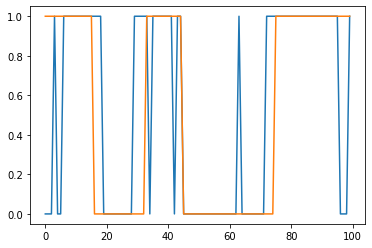

In [240]:
fig,ax = plt.subplots()
ax.plot(np.arange(N),s_true)
ax.plot(np.arange(N),VA(y,pys,pss))

In [36]:
def viterbi_accuracy(s_true,s_predicted):
    if s_true.shape[0] == s_predicted.shape[0]:
        N = s_true.shape[0]
    else:
        raise ValueError("Both state vectors must be of the same length")
    right = 0
    for i in range(N):
        if s_true[i] == s_predicted[i]: right += 1
    
    return right/N
viterbi_accuracy(s_true,VA(y,pys,pss))


0.94

### Baum-Welch Algorithm

In [52]:
# Initial parameters
pi0 = np.array([0.5,0.5])
a0 = [{0:0.8, 1:0.2},{0:0.1, 1:0.9}]
b0 = [{-1: 0.15, 0: 0.35, 1: 0.15, 2: 0.35},{-1: 0.35, 0: 0.15, 1: 0.35, 2: 0.15}]
n_states = len(a0)
ss = np.arange(n_states)
N = y.shape[0]
pi=pi0
a=a0
b=b0
print(pi0)
print(a0)
print(b0)

[0.5 0.5]
[{0: 0.8, 1: 0.2}, {0: 0.1, 1: 0.9}]
[{-1: 0.15, 0: 0.35, 1: 0.15, 2: 0.35}, {-1: 0.35, 0: 0.15, 1: 0.35, 2: 0.15}]


In [32]:
_, alfas, gammas = FA2(y,pi,b,a)
betas = BA(y,pi,b,a)
w = np.multiply(alfas,betas)
wprima = np.full([n_states,n_states,N-1],np.nan)
for t in range(N-1):
    for s_old in ss:
        for s_new in ss:
            wprima[s_old,s_new,t] = alfas[s_old,t]*a[s_old][s_new]*b[s_new][y[t+1]]*betas[s_new,t+1]/gammas[t+1]

for s_old in ss:
    pi[s_old] = w[s_old,1]
    for s_new in ss:
        a[s_old][s_new] = sum(wprima[s_old,s_new,t] for t in range(N-1))/sum(wprima[s_old,s,t] for s in ss for t in range(N-1))
    for yi in b[0].keys():
        b[s_old][yi] = sum(w[s_old,t] for t in range(N) if y[t] == yi)/sum(w[s_old,t] for t in range(N))

print(pi)
print(a)
print(b)

[0.87278421 0.12721579]
[{0: 0.5933770120685556, 1: 0.4066229879314447}, {0: 0.11394687815748732, 1: 0.886053121842513}]
[{-1: 0.10764296848655633, 0: 0.3113447868599152, 1: 0.3733137449951793, 2: 0.20769849965834916}, {-1: 0.3718644192195063, 0: 0.06150223483100243, 1: 0.4212156906149375, 2: 0.14541765533455384}]


In [57]:
def BWA(y,pi0,a0,b0,n_iter,n_talk=50):
    n_states = len(a0)
    ss = np.arange(n_states)
    N = y.shape[0]

    pi = pi0
    a = a0
    b = b0
    ys = b[0].keys()
    log = []
    log.append([a[0][0],a[1][1],b[0][-1],b[0][0],b[0][1],b[0][2],b[1][-1],b[1][0],b[1][1],b[1][2]])

    for iter in range(n_iter):
        prob, alfas, gammas = FA2(y,pi,b,a)
        betas = BA(y,pi,b,a)
        w = np.multiply(alfas,betas)
        wprima = np.full([n_states,n_states,N-1],np.nan)
        for t in range(N-1):
            for s_old in ss:
                for s_new in ss:
                    wprima[s_old,s_new,t] = alfas[s_old,t]*a[s_old][s_new]*b[s_new][y[t+1]]*betas[s_new,t+1]/gammas[t+1]

        for s_old in ss:
            pi[s_old] = w[s_old,1]
            for s_new in ss:
                a[s_old][s_new] = sum(wprima[s_old,s_new,t] for t in range(N-1))/sum(wprima[s_old,s,t] for s in ss for t in range(N-1))
            for yi in b[0].keys():
                b[s_old][yi] = sum(w[s_old,t] for t in range(N) if y[t] == yi)/sum(w[s_old,t] for t in range(N))
        log.append([a[0][0],a[1][1],b[0][-1],b[0][0],b[0][1],b[0][2],b[1][-1],b[1][0],b[1][1],b[1][2]])

        if iter%n_talk==0:
            print(f"Completed iterations: {iter}/{n_iter}")

    return pi,a,b,log

pi,a,b,log = BWA(y,pi0,a0,b0,1000,n_talk=100)
print(viterbi_accuracy(s_true,VA(y,b,a)))
print(pi)
print(a)
print(b)


Completed iterations: 0/1000
Completed iterations: 100/1000
Completed iterations: 200/1000
Completed iterations: 300/1000
Completed iterations: 400/1000
Completed iterations: 500/1000
Completed iterations: 600/1000
Completed iterations: 700/1000
Completed iterations: 800/1000
Completed iterations: 900/1000
0.76
[0.98649357 0.01350643]
[{0: 0.8014622957464786, 1: 0.19853770425352127}, {0: 0.11849150811228319, 1: 0.8815084918877166}]
[{-1: 1.2667698466953084e-110, 0: 0.22155829052758003, 1: 0.6800877330122453, 2: 0.09835397646017455}, {-1: 0.5127992988999938, 0: 0.05356145123717702, 1: 0.23331095839879967, 2: 0.20032829146402942}]
